In [51]:
import pandas as pd
import numpy as np

In [52]:
df = pd.read_csv("data.csv", index_col='Unnamed: 0')
df.head()

,9,17,18,23,46,86,99,104,128,158,...,135244,135273,135280,135281,135286,135313,135335,135339,135341,135353
466,3,0,0,0,0,0,7,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1721,10,8,0,5,0,0,8,0,0,0,...,0,6,0,6,6,0,7,0,5,5
2393,8,0,0,0,0,0,8,0,0,0,...,0,3,0,4,0,0,0,0,0,2
2852,9,0,0,0,0,0,0,0,0,0,...,0,4,0,5,0,0,0,0,0,2
3248,5,10,0,0,0,0,0,0,0,6,...,0,2,0,0,0,1,0,0,0,2


In [53]:
def get_mae(pred, actual):
    pred = pred.as_matrix()
    actual = actual.as_matrix()
    # Ignore zero terms.
    pred = pred.flatten()[actual.flatten().nonzero()] 
    actual = actual.flatten()[actual.flatten().nonzero()]
    mae = sum(abs(pred - actual)) / len(pred)
    return round(mae, 4)

In [54]:
def get_rmse(pred, actual):
    pred = pred.as_matrix()
    actual = actual.as_matrix()
    # Ignore zero terms.
    pred = pred.flatten()[actual.flatten().nonzero()] 
    actual = actual.flatten()[actual.flatten().nonzero()]
    rmse = (sum((pred - actual)**2) / len(pred))**0.5
    return round(rmse, 4)

# Baseline

In [55]:
def baseline_acc(df):    
    # build baseline prediction
    row_sum = df.sum(axis=1)
    row_non0 = (df != 0).astype(int).sum(axis=1)
    user_bias = np.around(row_sum / row_non0, decimals=4)
    prediction_baseline = np.ones(df.shape[1]) * user_bias.values[:, np.newaxis]
    pred = pd.DataFrame(prediction_baseline, index=df.index, columns=df.columns)
    
    # MAE
    mae = get_mae(pred, df)
    rmse = get_rmse(pred, df)
    return 'MAE: ' + str(mae) + ' RMSE: ' + str(rmse)

In [56]:
baseline_acc(df)

'MAE: 1.1899 RMSE: 1.8014'

# Split and Cross Vaildation

In [57]:
def split_dataset(df, per):
    import random as rd
    train = df.copy()
    for row in df.index:
        col_index = (df.columns.values).tolist() # 1000 male
        rd.shuffle(col_index)
        hidden_index = col_index[0: int(len(col_index)*per)]
        for col in hidden_index:
            train.loc[row, str(col)] = 0
    test = df - train
    return train, test 

In [58]:
train, test = split_dataset(df, 0.2)

In [59]:
import time
def cross_vaildation(df, algo, param):
    tStart = time.time()
    train, test = split_dataset(df, 0.2) # 80% train, 20% test
    pred = algo(train, param) # run model
    
    mae = get_mae(pred, test)
    rmse = get_rmse(pred, test)
    print(time.time()-tStart)
    return pred, test, mae, rmse

# Model Base

In [60]:
def base_line_prediction(df):
    df_baseline = df.copy()
    row_sum = df_baseline.sum(axis=1)
    row_non0 = (df_baseline != 0).astype(int).sum(axis=1)
    user_bias = np.around(row_sum / row_non0, decimals=4)
    for row in df_baseline.index.values:
        df_baseline.loc[row, :] = df.loc[row].replace(0,user_bias[row])
        
    return df_baseline

In [61]:
import matplotlib.pyplot as plt
%matplotlib inline
# add training + test two lines?
def plot_singular_values_of_A(df):
    df_baseline = base_line_prediction(df)
    df_baseline.as_matrix()
    u,s,vt = np.linalg.svd(df_baseline)
    fig = plt.figure(figsize=(6,4))
    plt.plot(range(1,len(s)+1),s)
    plt.xlabel(r'$k$',size=20)
    plt.ylabel(r'$\sigma_k$',size=20)
    _ = plt.title(r'Singular Values of $A$',size=20)

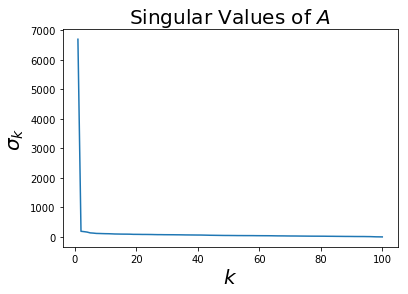

In [62]:
plot_singular_values_of_A(df)

In [69]:
def matrix_factorization(R, K, steps=100, alpha=0.0002, beta=0.02):
    R_index, R_col = R.index, R.columns
    R = R.as_matrix()
    u,s,v = np.linalg.svd(R)
    a = []
    for i in range(K):
        a.append(i)
    P = pd.DataFrame(u)[a].as_matrix()
    Q = v[0:K]
    N = R.shape[0]
    M = R.shape[1]
    nonzero = list(zip(np.nonzero(R)[0].tolist(), np.nonzero(R)[1].tolist()))
    for step in range(steps):
        #print (step)
        for pair in nonzero:
            i = pair[0]
            j = pair[1]
            eij = R[i][j] - np.dot(P[i,:],Q[:,j])
            for k in range(K):
                P[i][k] = P[i][k] + alpha * (2 * eij * Q[k][j] - beta * P[i][k])
                Q[k][j] = Q[k][j] + alpha * (2 * eij * P[i][k] - beta * Q[k][j])
        eR = np.dot(P,Q)
        e = 0
        for pair in nonzero:
            i = pair[0]
            j = pair[1]
            e = e + pow(R[i][j] - eR[i][j], 2)
            for k in range(K):
                e = e + (beta/2) * ( pow(P[i][k],2) + pow(Q[k][j],2) )
        if e < 0.01:
            break
    #return P, Q.T
    return pd.DataFrame(data=P.dot(Q), index=R_index, columns=R_col)

In [70]:
model_pred, model_test, model_mae, model_rmse = cross_vaildation(df, matrix_factorization, 10)

1020.09370303


In [71]:
model_mae

1.2586

In [72]:
model_rmse

1.8247

In [73]:
model_pred.head()

,9,17,18,23,46,86,99,104,128,158,...,135244,135273,135280,135281,135286,135313,135335,135339,135341,135353
466,6.657511,5.934026,5.399052,5.088021,5.692354,5.131618,6.344875,5.258711,4.981832,5.559965,...,5.252973,5.272814,5.650263,5.524848,5.754240,6.575571,5.725094,3.357539,4.124989,4.952146
1721,8.153336,8.200400,5.441285,4.911599,7.559390,6.945086,7.320347,6.604943,4.673986,7.203310,...,6.050931,6.303437,7.509879,6.020159,5.774786,7.902732,6.402108,5.460695,4.053592,5.738475
2393,6.327681,4.911513,3.889166,3.369934,4.757748,3.872860,5.768460,4.303055,3.265601,5.193666,...,3.702269,2.482625,5.677122,5.519378,3.876666,5.495752,4.815345,2.860334,2.178547,3.204356
2852,4.807064,4.131871,3.856034,2.834613,4.624909,3.885197,4.299469,4.024825,2.901842,4.515405,...,3.602006,2.948502,4.973499,4.180019,3.715388,4.554167,4.584092,2.889337,1.985127,3.953363
3248,8.087417,5.939639,3.969177,3.374790,4.626072,4.129621,6.067361,3.425711,2.917459,5.047114,...,3.812708,2.607971,5.414194,5.702215,3.510479,6.224970,4.270404,2.889502,1.774934,2.758553


In [74]:
model_rmse

1.8247

In [ ]:
# 3 parameter needed for different k values, graphs.

In [75]:
model_pred_8, model_test_8, model_mae_8, model_rmse_8 = cross_vaildation(df, matrix_factorization, 8)

757.597630024


In [76]:
model_rmse_8

1.8299

In [77]:
model_pred_12, model_test_12, model_mae_12, model_rmse_12 = cross_vaildation(df, matrix_factorization, 12)

973.121387005


In [78]:
model_pred_6, model_test_6, model_mae_6, model_rmse_6 = cross_vaildation(df, matrix_factorization, 6)

571.639168978


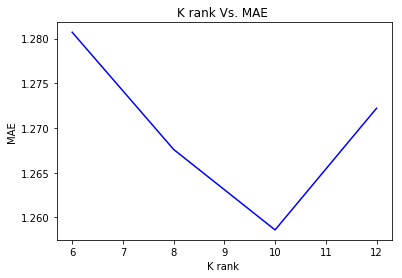

In [86]:
import matplotlib.pyplot as plt
%matplotlib inline
# plot with MAE
# need to add label
# plot with RMSE
plt.xlabel('K rank ')
plt.ylabel('MAE')
plt.title('K rank Vs. MAE ')
plt.plot([6,8,10,12], [model_mae_6,model_mae_8,model_mae,model_mae_12], c='blue')
#plt.axis([0, 11, 0.9, 1.4])
plt.show()

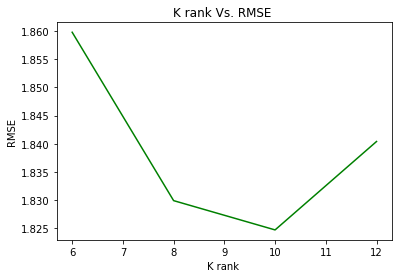

In [80]:
%matplotlib inline
# plot with MAE
# need to add label
# plot with RMSE
plt.xlabel('K rank ')
plt.ylabel('RMSE')
plt.title('K rank Vs. RMSE ')
plt.plot([6,8,10,12], [model_rmse_6,model_rmse_8,model_rmse,model_rmse_12], c='green')
#plt.axis([0, 11, 0.9, 1.4])
plt.show()


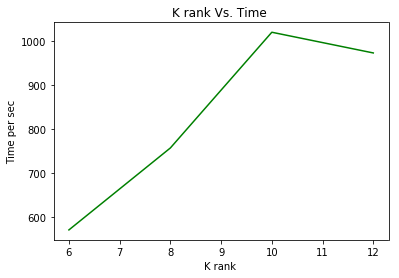

In [82]:
plt.xlabel('K rank ')
plt.ylabel('Time per sec')
plt.title('K rank Vs. Time ')
plt.plot([6,8,10,12], [571.639168978,757.59763,1020.09370303,973.121387005], c='green')
#plt.axis([0, 11, 0.9, 1.4])
plt.show()



### It can be shown that when rank = k, both RMSE and MSE reahes a minimum, and its computational cost is largest.